# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In this notebook we figure out constratins on the following parameters for two deflectors such that they can be used as pseudo double source plane lenses:
- $Δ\sigma_v$ - the difference in velocity dispersion between the two deflectors
- $Δz$ - the difference in redshift between the two deflectors
- $Δm$ - the difference in magnitude between the two deflectors for different bands
- $Δ\text{size}$ - the difference in size between the two deflectors.


In [1]:
import matplotlib.pyplot as plt
# from astropy.cosmology import FlatLambdaCDM
# from astropy.units import Quantity
# from slsim.lens_pop import LensPop
# from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
# import slsim.Pipelines as pipelines
# import slsim.Sources as sources
# import slsim.Deflectors as deflectors
# from slsim.lens import Lens
# from slsim.image_simulation import lens_image, rgb_image_from_image_list
# from slsim.Util.param_util import gaussian_psf
# # import standard python modules
# import copy
# import matplotlib.patches as mpatches
# from itertools import combinations
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import binned_statistic_2d

%matplotlib inline

# import lenstronomy and hierArc modules
# from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
# from hierarc.Sampling.mcmc_sampling import MCMCSampler

# from hierarc.Likelihood.LensLikelihood.double_source_plane import (
#     beta_double_source_plane,
#     beta2theta_e_ratio,
# )
from astropy.table import Table


def plot_heatmap_fast(x, y, z, x_resolution, y_resolution,
                      agg_func='mean', # Common choices: 'mean', 'median', 'count', 'sum'
                      cmap='viridis',
                      xlabel="Parameter X",
                      ylabel="Parameter Y",
                      zlabel="Parameter Z",
                      title="Heatmap",
                      figsize=(8, 6),
                      ax=None,
                      vmin=None,
                      vmax=None):
    """
    Generates a heatmap from scattered 3D data (x, y, z) using fast 2D binning.

    Args:
        x (np.ndarray): 1D array of x-coordinates.
        y (np.ndarray): 1D array of y-coordinates.
        z (np.ndarray): 1D array of z-values (determining color).
        x_resolution (int): Number of bins along the x-axis.
        y_resolution (int): Number of bins along the y-axis.
        agg_func (str, optional): Aggregation function for binning ('mean',
            'median', 'count', 'sum', etc.). Defaults to 'mean'.
        cmap (str, optional): Matplotlib colormap name. Defaults to 'viridis'.
        xlabel (str, optional): Label for the x-axis. Defaults to "Parameter X".
        ylabel (str, optional): Label for the y-axis. Defaults to "Parameter Y".
        zlabel (str, optional): Label for the color bar. Defaults to "Parameter Z".
        title (str, optional): Title for the plot. Defaults to "Heatmap".
        figsize (tuple, optional): Figure size if creating a new figure.
            Defaults to (8, 6).
        ax (matplotlib.axes.Axes, optional): Pre-existing axes to plot on.
            If None, a new figure and axes are created. Defaults to None.
        vmin (float, optional): Minimum value for the color scale. Defaults to
            the minimum of the aggregated data.
        vmax (float, optional): Maximum value for the color scale. Defaults to
            the maximum of the aggregated data.


    Returns:
        matplotlib.axes.Axes: The axes object containing the plot.

    Raises:
        ValueError: If input arrays are not 1D or have mismatched shapes,
                    or if resolutions are not positive.
        ImportError: If scipy is not installed.
    """
    # --- Input Validation ---
    if not all(isinstance(arr, np.ndarray) and arr.ndim == 1 for arr in [x, y, z]):
        raise ValueError("x, y, z must be 1D NumPy arrays.")
    if not (x.shape == y.shape == z.shape):
        raise ValueError("x, y, z must have the same shape.")
    if not (isinstance(x_resolution, int) and x_resolution > 0 and
            isinstance(y_resolution, int) and y_resolution > 0):
         raise ValueError("x_resolution and y_resolution must be positive integers.")

    # --- Data Range ---
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)

    # Handle case where min == max to avoid zero range
    if xmin == xmax:
        xmin -= 0.5
        xmax += 0.5
    if ymin == ymax:
        ymin -= 0.5
        ymax += 0.5

    # --- Perform Binning ---
    # Calculate the statistic (e.g., mean z) for each bin
    # range parameter ensures consistent bin edges even if data doesn't span the full range
    statistic, x_edge, y_edge, _ = binned_statistic_2d(
        x, y, z,
        statistic=agg_func,
        bins=[x_resolution, y_resolution],
        range=[[xmin, xmax], [ymin, ymax]]
    )

    # Transpose for pcolormesh: statistic[i, j] corresponds to x_edge[i] and y_edge[j]
    # pcolormesh(X, Y, C) expects C[j, i] for X[i], Y[j]
    plot_data = statistic.T

    # Mask bins with no data (NaN result from binned_statistic_2d)
    plot_data_masked = np.ma.masked_invalid(plot_data)

    # --- Determine Color Limits ---
    if vmin is None:
        vmin = np.ma.min(plot_data_masked)
        if vmin is None or np.ma.is_masked(vmin): # Handle case where all data is masked
             vmin = np.min(z) if len(z) > 0 else 0 # Fallback
    if vmax is None:
        vmax = np.ma.max(plot_data_masked)
        if vmax is None or np.ma.is_masked(vmax):
             vmax = np.max(z) if len(z) > 0 else 1 # Fallback

    # --- Plotting ---
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    im = ax.pcolormesh(x_edge, y_edge, plot_data_masked, cmap=cmap,
                       shading='flat', vmin=vmin, vmax=vmax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plot_title = f"{title} ({agg_func.capitalize()} per Bin)"
    ax.set_title(plot_title)
    ax.axis([xmin, xmax, ymin, ymax]) # Set view limits precisely

    cbar_label = f"{zlabel} ({agg_func.capitalize()})"
    fig.colorbar(im, ax=ax, label=cbar_label)

    return ax

import warnings

# (metric_to_weights function remains the same - unchanged)
def metric_to_weights(metric_values, method='exp_neg', k=1.0):
    """
    Converts a 'lower-is-better' metric into non-negative weights for corner plots.

    Args:
        metric_values (np.ndarray): Array of metric values (e.g., chi2, neg_logL, difference).
                                     Lower values indicate higher preference.
        method (str): How to convert the metric into weights:
            'exp_neg': Use exponential decay: exp(-k * metric). Good for general
                       differences or cost functions. Uses the 'k' parameter.
            'chi2': Assume input is chi-squared, compute exp(-chi2 / 2). Ignores 'k'.
            'neg_loglike': Assume input is negative log-likelihood, compute exp(-neg_logL).
                           Ignores 'k'. Equivalent to 'exp_neg' with k=1 IF metric is already neg_logL.

        k (float): Positive scaling factor for the 'exp_neg' method. Controls how
                   quickly weights decrease as the metric increases. Defaults to 1.0.

    Returns:
        np.ndarray: Non-negative weights where higher values correspond to lower input metrics.
    """
    values = np.asarray(metric_values)

    if method == 'exp_neg':
        if k <= 0:
            raise ValueError("Factor 'k' must be positive for method 'exp_neg'")
        # Avoid potential issues with large positive/negative values by shifting
        with warnings.catch_warnings(): # Suppress potential RuntimeWarning from overflow/underflow before check
             warnings.simplefilter("ignore", category=RuntimeWarning)
             min_val = np.min(values[np.isfinite(values)]) if np.any(np.isfinite(values)) else 0
             shifted_values = values - min_val
             weights = np.exp(-k * shifted_values)
    elif method == 'chi2':
        min_chi2 = np.min(values[np.isfinite(values)]) if np.any(np.isfinite(values)) else 0
        shifted_values = values - min_chi2
        weights = np.exp(-shifted_values / 2.0)
    elif method == 'neg_loglike':
        min_neg_logl = np.min(values[np.isfinite(values)]) if np.any(np.isfinite(values)) else 0
        shifted_values = values - min_neg_logl
        weights = np.exp(-shifted_values)
    else:
        raise ValueError(f"Unknown weight conversion method for low-is-better metric: {method}")

    # Ensure weights are non-negative and finite
    weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0) # Replace non-finite with 0
    weights = np.maximum(weights, 0) # Ensure non-negative

    return weights


def plot_low_metric_weighted_corner(
    data_dict,
    param_keys,
    metric_key,
    labels_dict=None,
    conversion_method='exp_neg',
    k_factor=1.0,
    corner_kwargs=None,
    mask=None, # Added mask parameter
):
    """
    Creates a corner plot from parallel 1D data arrays, weighting points
    inversely based on a 'lower-is-better' metric array, optionally
    filtering data with a boolean mask.

    **Note:** This function reads data from `data_dict` but does not modify
    the input dictionary or its contained arrays in any way.

    Args:
        data_dict (dict): Dictionary where keys map to 1D NumPy arrays of the
                          same length. (Will not be modified).
        param_keys (list): List of keys in data_dict to be used as parameters
                           (plot axes).
        metric_key (str): The key in data_dict holding the metric where lower
                          values are preferred (e.g., chi2, difference).
        labels_dict (dict, optional): Maps parameter keys to LaTeX labels.
        conversion_method (str, optional): Method to convert the metric_key array
                                           into weights. See metric_to_weights().
                                           Defaults to 'exp_neg'.
        k_factor (float, optional): Scaling factor 'k' if using method 'exp_neg'.
                                   Defaults to 1.0.
        corner_kwargs (dict, optional): Additional keyword arguments passed
                                        directly to corner.corner().
        mask (np.ndarray[bool], optional): Boolean mask array of the same length
                                           as data arrays. If provided, only
                                           data where mask is True will be plotted.
                                           Defaults to None (use all data).

    Returns:
        matplotlib.figure.Figure: The figure object created by corner.corner,
                                   or None if plotting failed.
    """
    if corner_kwargs is None:
        corner_kwargs = {}
    if labels_dict is None:
        labels_dict = {}

    # --- 1. Initial Validation & Data Reading ---
    if not param_keys:
        warnings.warn("No parameter keys provided.")
        return None

    if metric_key not in data_dict:
        raise ValueError(f"Metric key '{metric_key}' not found in data_dict.")

    original_n_samples = -1
    param_arrays_all = [] # Store all original arrays first
    for i, key in enumerate(param_keys):
        if key not in data_dict:
            raise ValueError(f"Parameter key '{key}' not found in data_dict.")
        arr = np.asarray(data_dict[key])
        if arr.ndim != 1:
            raise ValueError(f"Array for key '{key}' is not 1-dimensional.")
        if i == 0:
            original_n_samples = len(arr)
        elif len(arr) != original_n_samples:
            raise ValueError(f"Length mismatch: Key '{key}' has length {len(arr)}, "
                             f"expected {original_n_samples}.")
        param_arrays_all.append(arr)

    metric_values_all = np.asarray(data_dict[metric_key])
    if metric_values_all.ndim != 1:
         raise ValueError(f"Array for metric key '{metric_key}' is not 1-dimensional.")
    if len(metric_values_all) != original_n_samples:
         raise ValueError(f"Length mismatch: Metric key '{metric_key}' has length "
                          f"{len(metric_values_all)}, expected {original_n_samples}.")

    if original_n_samples == 0:
        warnings.warn("Input data has zero samples.")
        return None

    # --- 2. Apply Mask (if provided) ---
    current_mask = None # To store the validated mask
    if mask is not None:
        try:
            current_mask = np.asarray(mask, dtype=bool)
        except Exception as e:
            raise TypeError(f"Failed to convert provided mask to boolean array: {e}")

        if current_mask.ndim != 1:
             raise ValueError(f"Mask must be 1-dimensional, but got ndim={current_mask.ndim}")
        if len(current_mask) != original_n_samples:
            raise ValueError(f"Mask length ({len(current_mask)}) does not match data length "
                             f"({original_n_samples}).")

        n_samples_after_mask = np.sum(current_mask)
        print(f"Applying mask: {n_samples_after_mask} out of {original_n_samples} samples selected.")

        if n_samples_after_mask == 0:
            warnings.warn("Mask filtered out all data points. Cannot generate plot.")
            return None

        # Apply the mask to all arrays
        param_arrays_masked = [arr[current_mask] for arr in param_arrays_all]
        metric_values_masked = metric_values_all[current_mask]
        n_samples_to_plot = n_samples_after_mask

    else:
        # No mask, use all data
        param_arrays_masked = param_arrays_all
        metric_values_masked = metric_values_all
        n_samples_to_plot = original_n_samples
        print("No mask provided, using all data.")


    # --- 3. Prepare Data for Corner (using potentially masked data) ---
    # Stack parameter arrays: creates a new array of shape (n_samples_to_plot, n_params)
    samples = np.stack(param_arrays_masked, axis=-1)

    # Convert metric values to weights: metric_to_weights creates a new array
    try:
        weights = metric_to_weights(metric_values_masked, method=conversion_method, k=k_factor)
        print(f"Converted metric '{metric_key}' to weights using method '{conversion_method}'"
              f"{f' with k={k_factor}' if conversion_method == 'exp_neg' else ''}.")
    except Exception as e:
         raise ValueError(f"Failed to convert '{metric_key}' to weights using method "
                          f"'{conversion_method}': {e}")

    # Check if weights are valid after potential masking
    sum_weights = np.sum(weights)
    if sum_weights <= 1e-15 * n_samples_to_plot or not np.isfinite(sum_weights):
        # Use a relative threshold based on the number of points being plotted
        warnings.warn(f"Sum of weights derived from '{metric_key}' is near zero or invalid "
                      f"({sum_weights:.2e}) after applying mask (if any). Corner plot might be "
                      "empty or misleading. Check metric values and conversion method.")
        # Decide if you want to proceed or return None
        # Proceeding might result in an empty plot or errors from corner itself
        # return None

    # --- 4. Plot with corner ---
    plot_labels = [labels_dict.get(k, k) for k in param_keys]

    # Default corner settings
    default_kwargs = {
        'labels': plot_labels,
        'show_titles': True,
        'title_kwargs': {"fontsize": 10},
        'quantiles': [0.16, 0.5, 0.84],
        'plot_datapoints': False,
        'fill_contours': True,
        'smooth': 0.9,
        'bins': 30,
    }
    default_kwargs.update(corner_kwargs) # User kwargs override defaults

    print(f"Generating corner plot for {n_samples_to_plot} weighted samples...")
    try:
        # Pass the potentially masked samples and weights arrays to corner
        figure = corner.corner(samples, weights=weights, **default_kwargs)
        print("Plot generation complete.")
        return figure
    except Exception as e:
        print(f"Error during corner plot generation: {e}")
        import traceback # Optional: Print full traceback for debugging
        traceback.print_exc()
        return None


In [2]:
# Load the pairing parameters table
loaded_pairing_parameters_table = Table.read(
    "pairing_parameters_table_6Mil.fits",
    format="fits",
)

# get the differences in deflector magnitudes, sizes as well as a column in the table
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_i"] - loaded_pairing_parameters_table["mag_D2_i"],
    name="delta_mag_i_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_r"] - loaded_pairing_parameters_table["mag_D2_r"],
    name="delta_mag_r_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_g"] - loaded_pairing_parameters_table["mag_D2_g"],
    name="delta_mag_g_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_z"] - loaded_pairing_parameters_table["mag_D2_z"],
    name="delta_mag_z_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_y"] - loaded_pairing_parameters_table["mag_D2_y"],
    name="delta_mag_y_D",
)

# get the differences in source size as well as a column in the table
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["size_D1"] - loaded_pairing_parameters_table["size_D2"],
    name="delta_size_D",
)

# absolute differences in deflector magnitudes, sizes as well as a column in the table
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_i"] - loaded_pairing_parameters_table["mag_D2_i"]),
    name="abs_delta_mag_i_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_r"] - loaded_pairing_parameters_table["mag_D2_r"]),
    name="abs_delta_mag_r_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_g"] - loaded_pairing_parameters_table["mag_D2_g"]),
    name="abs_delta_mag_g_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_z"] - loaded_pairing_parameters_table["mag_D2_z"]),
    name="abs_delta_mag_z_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_y"] - loaded_pairing_parameters_table["mag_D2_y"]),
    name="abs_delta_mag_y_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["size_D1"] - loaded_pairing_parameters_table["size_D2"]),
    name="abs_delta_size_D",
)


# add the absolute differences in beta to the pairing_parameters table
abs_diff_theta_E_1 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
)
abs_diff_theta_E_2 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"]
)

loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_1,
    name="abs_diff_theta_E_1",
)
loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_2,
    name="abs_diff_theta_E_2",
)



# remove infs and nans in theta_E_ratio and theta_E1_by_theta_E2_virtual and theta_E1_virtual_by_theta_E2
mask = np.isfinite(loaded_pairing_parameters_table["theta_E_ratio"]) & np.isfinite(
    loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
) & np.isfinite(loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"])
mask &= ~np.isnan(loaded_pairing_parameters_table["theta_E_ratio"]) & ~np.isnan(
    loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
) & ~np.isnan(loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"])
mask &= loaded_pairing_parameters_table["theta_E_ratio"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"] < 1e3
mask &= loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"] < 1e3

loaded_pairing_parameters_table = loaded_pairing_parameters_table[mask]

# make the dict from the table
pairing_parameters = dict(loaded_pairing_parameters_table)

# print the table
loaded_pairing_parameters_table

z_D1,z_D2,z_S1,z_S2,theta_E1,theta_E2,theta_E_ratio,theta_E1_virtual,theta_E2_virtual,theta_E1_by_theta_E2_virtual,theta_E1_virtual_by_theta_E2,sigma_v_D1,sigma_v_D2,beta_DSPL_D1,beta_DSPL_D2,delta_z_D,delta_sigma_v_D,abs_delta_z_D,abs_delta_sigma_v_D,mag_S1_i,mag_S2_i,mag_S1_r,mag_S2_r,mag_S1_g,mag_S2_g,mag_S1_z,mag_S2_z,mag_S1_y,mag_S2_y,mag_D1_i,mag_D2_i,mag_D1_r,mag_D2_r,mag_D1_g,mag_D2_g,mag_D1_z,mag_D2_z,mag_D1_y,mag_D2_y,size_D1,size_D2,delta_mag_i_D,delta_mag_r_D,delta_mag_g_D,delta_mag_z_D,delta_mag_y_D,delta_size_D,abs_delta_mag_i_D,abs_delta_mag_r_D,abs_delta_mag_g_D,abs_delta_mag_z_D,abs_delta_mag_y_D,abs_delta_size_D,abs_diff_theta_E_1,abs_diff_theta_E_2
,,,,arcsec,arcsec,,arcsec,arcsec,,,km / s,km / s,,,,km / s,,km / s,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,rad,rad,mag,mag,mag,mag,mag,rad,mag,mag,mag,mag,mag,rad,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.3820624417152292,2.108541578155249,2.6434964327981225,3.8369728740815106,0.15948790748146047,0.2767404924332489,0.5763085339595893,0.12435778071831056,0.21694321805813543,0.7351596832988881,0.4493660455139439,130.62627829399077,198.2789915889441,0.7475577100359314,0.4493660455139439,-0.7264791364400196,-67.65271329495334,0.7264791364400196,67.65271329495334,26.511171315418938,26.985589869890063,26.700172344893392,26.979375347809302,26.8106211835907,27.552072637961402,26.509064729661343,26.88240048025944,26.387761932214968,26.852842834341878,23.442563846098864,22.84616353326623,23.732827859126886,23.05666118977274,23.84783743349289,23.354000132342634,23.168948960877515,22.53553252914117,22.685583951294646,22.331071153594493,0.45904889216655315,1.172952448578423,0.5964003128326354,0.6761666693541457,0.4938373011502577,0.6334164317363431,0.35451279770015276,-0.7139035564118699,0.5964003128326354,0.6761666693541457,0.4938373011502577,0.6334164317363431,0.35451279770015276,0.7139035564118699,0.1588511493392989,0.12694248844564537
1.3820624417152292,0.8677986834088184,2.6434964327981225,1.5842741767829696,0.15948790748146047,0.5473299961974719,0.29139259421096775,0.7992255666158121,0.041570111204880085,3.8366004530374584,1.4602261381038186,130.62627829399077,237.52304191527455,3.70381006561787,1.4724290395171675,0.5142637583064108,-106.89676362128378,0.5142637583064108,106.89676362128378,26.511171315418938,26.591232211109276,26.700172344893392,27.133048957084146,26.8106211835907,27.497325877748136,26.509064729661343,26.248882125274672,26.387761932214968,25.83188405289629,23.442563846098864,20.642862514405305,23.732827859126886,21.479693852757467,23.84783743349289,22.218468730723405,23.168948960877515,20.142065748321148,22.685583951294646,19.951139695234478,0.45904889216655315,1.341260604853299,2.7997013316935586,2.253134006369418,1.6293687027694865,3.026883212556367,2.7344442560601685,-0.8822117126867457,2.7997013316935586,2.253134006369418,1.6293687027694865,3.026883212556367,2.7344442560601685,0.8822117126867457,3.545207858826491,1.168833543892851
1.3820624417152292,0.6418069536959404,2.6434964327981225,2.35255544079326,0.15948790748146047,0.20342043710214563,0.7840308955848676,0.211225678057299,0.13718430827714115,1.1625812710245356,1.0383699940199913,130.62627829399077,111.5776410767352,1.154970318998,1.039810213988341,0.7402554880192888,19.04863721725556,0.7402554880192888,19.04863721725556,26.511171315418938,27.240045614261163,26.700172344893392,27.40300822330707,26.8106211835907,27.637546852020975,26.509064729661343,27.10558958537655,26.387761932214968,26.85188493603458,23.442563846098864,21.51113061479346,23.732827859126886,21.

In [3]:
## cosmology of the stored lenses

# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo = cosmo_param.cosmo(kwargs_cosmo_true)

Text(0.5, 0.95, 'Observed Pairing Parameters')

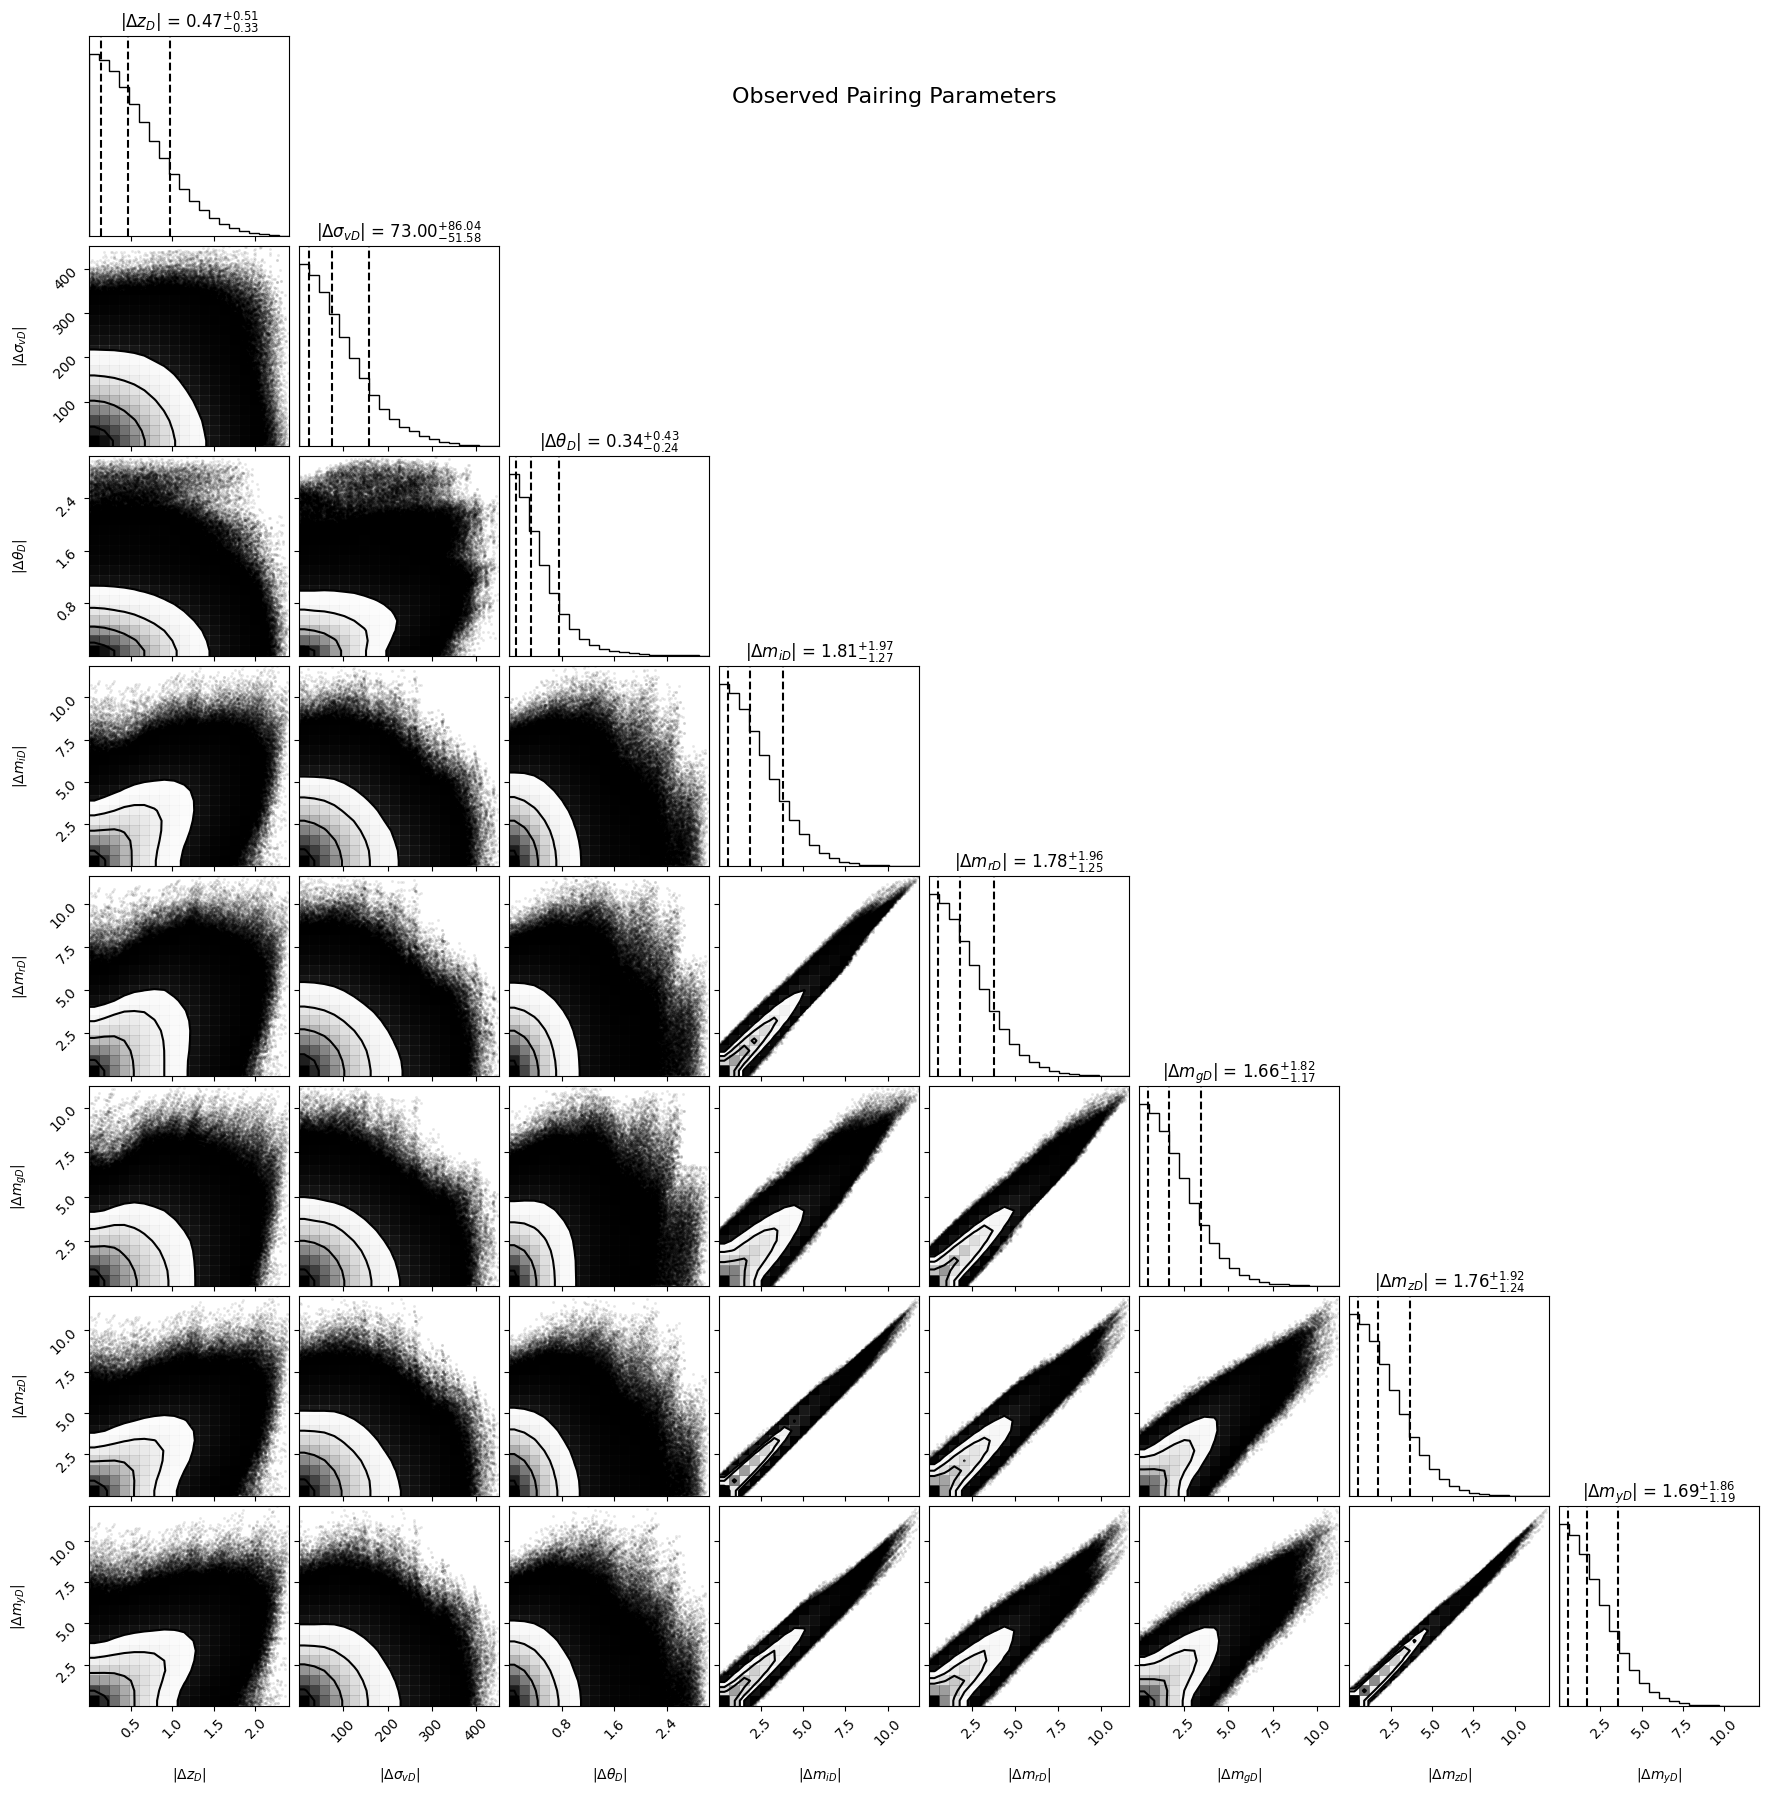

In [4]:
# make a corner plot featuring delta_z_D, delta_sigma_v_D, delta_size_D, delta_mag_D

# Define the exact order of parameters we want to plot:
keys = [
    "abs_delta_z_D", 
    "abs_delta_sigma_v_D",
    "abs_delta_size_D", 
    "abs_delta_mag_i_D",
    "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    "abs_delta_mag_z_D",
    "abs_delta_mag_y_D",
]

latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
    "abs_delta_size_D": r"$|\Delta \theta_D|$",
    "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
)
fig.suptitle(
    f"Observed Pairing Parameters",
    fontsize=16,
    y=0.95,
)

Text(0.5, 0.95, 'Observed Pairing Parameters')

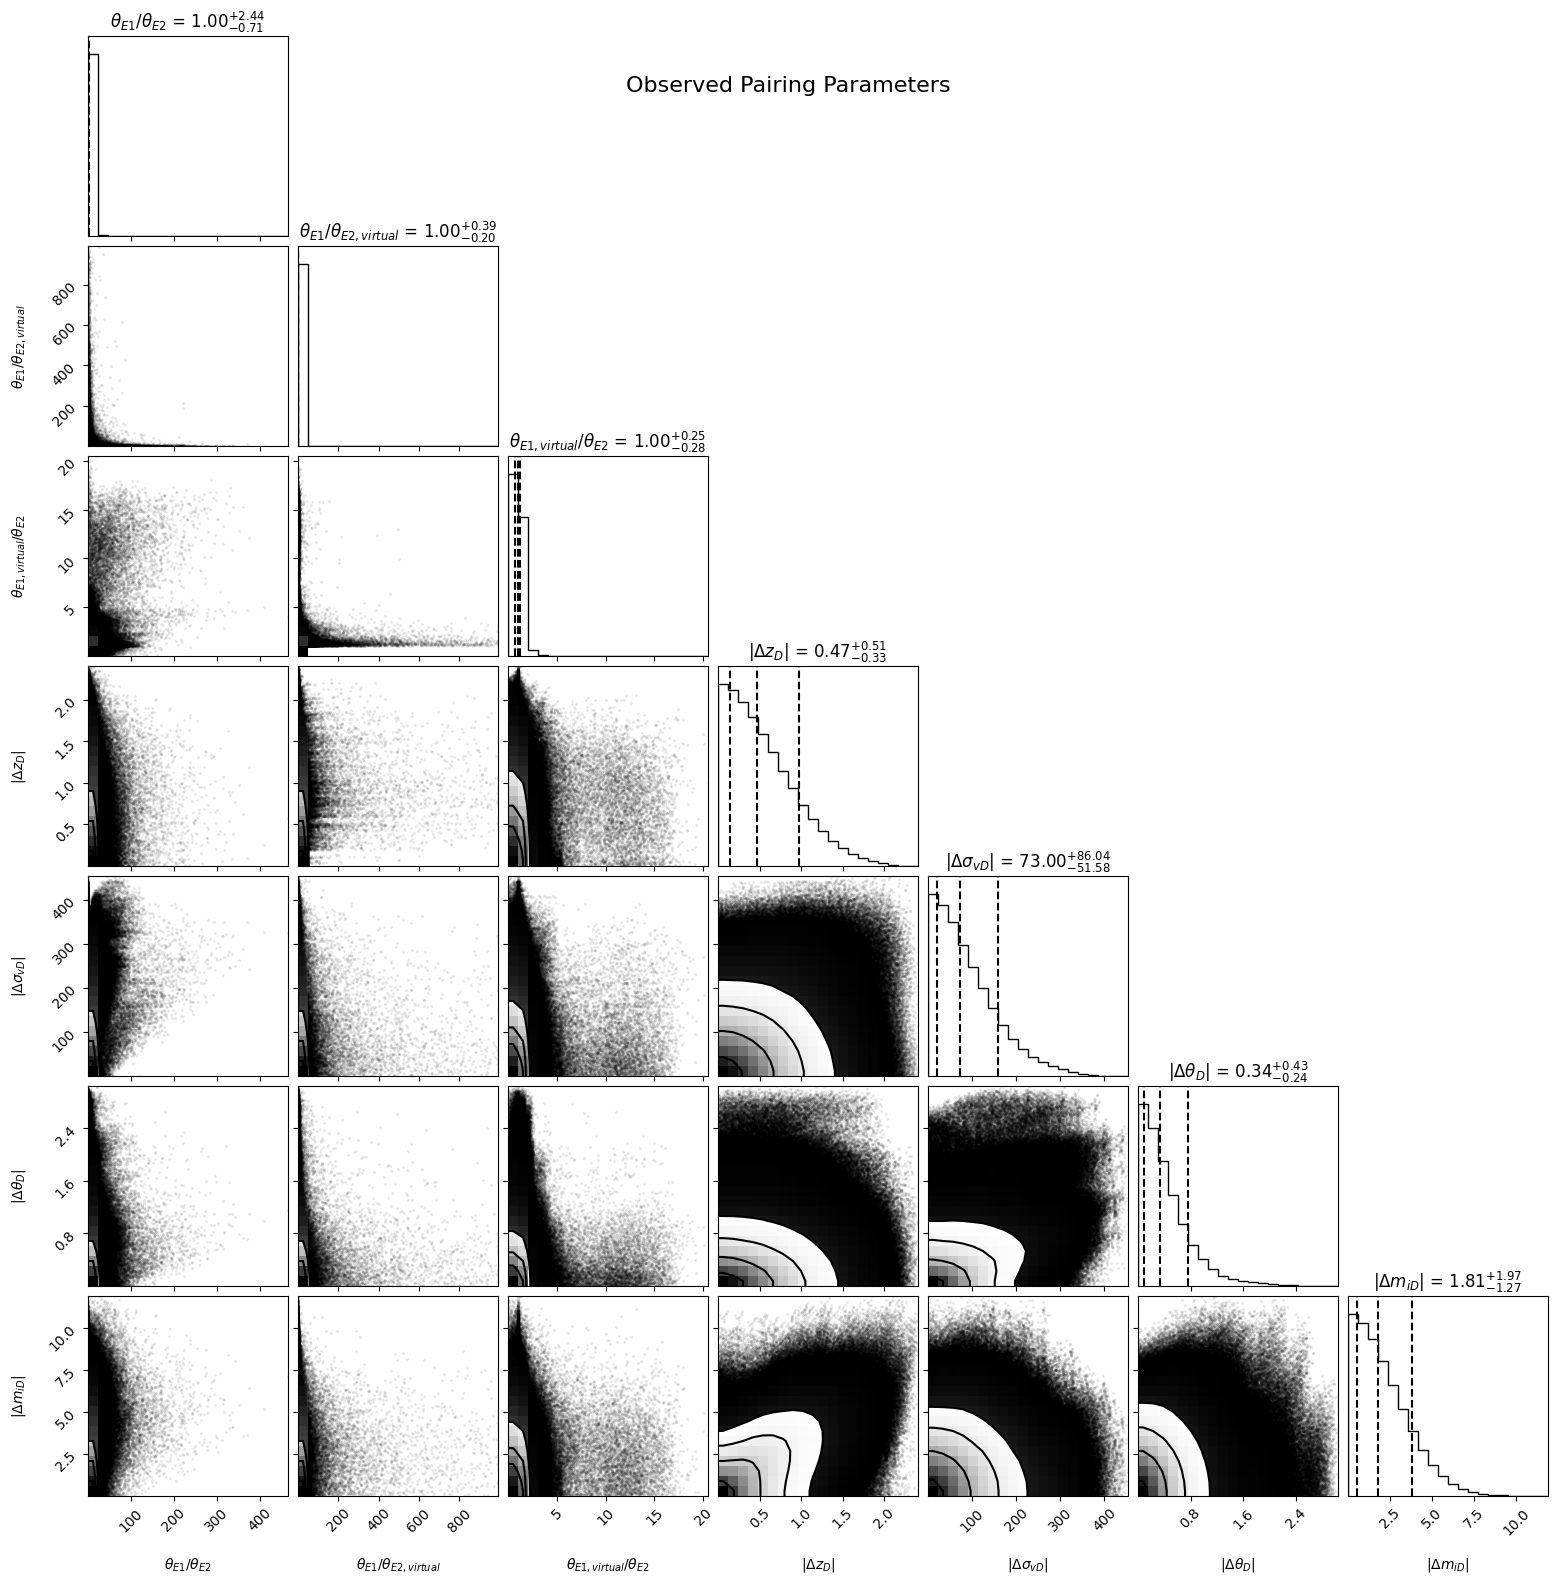

In [5]:
# make a corner plot including theta_E_ratio, theta_E1_by_theta_E2_virtual, theta_E1_virtual_by_theta_E2, delta_z_D, delta_sigma_v_D, delta_size_D, delta_mag_i_D

# Define the exact order of parameters we want to plot:
keys = [
    "theta_E_ratio",
    "theta_E1_by_theta_E2_virtual",
    "theta_E1_virtual_by_theta_E2",
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    "abs_delta_mag_i_D",
]

latex_labels = {
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_by_theta_E2_virtual": r"$\theta_{E1}/\theta_{E2, virtual}$",
    "theta_E1_virtual_by_theta_E2": r"$\theta_{E1, virtual}/\theta_{E2}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
    "abs_delta_size_D": r"$|\Delta \theta_D|$",
    "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
)
fig.suptitle(
    f"Observed Pairing Parameters",
    fontsize=16,
    y=0.95,
)

## CRITERION FOR PDSPL

Finding the best $|Δz_D|$, $|Δσ_{v,D}|$, $|Δm_D|$, $|Δ\theta_D|$ such that the pair can be treated as PDSPL!

Use a metric to quantify how similar the two deflectors are such that they can be treated as PDSPL.

$$\text{metric1} = \left|\frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1, virtual}}{\theta_{E2}}\right|$$

$$\text{metric2} = \left|\frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}}\right|$$

<!-- $$\text{metric3} = \left|\frac{\theta_{E1, virtual}}{\theta_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}}\right|$$ -->

Mask defined. Number of points satisfying mask: 233224

Plotting 8 parameters using 'abs_diff_theta_E_1' for metric (converted via method='chi2').
Applying mask: 233224 out of 5361167 samples selected.
Converted metric 'abs_diff_theta_E_1' to weights using method 'chi2'.
Generating corner plot for 233224 weighted samples...
Plot generation complete.


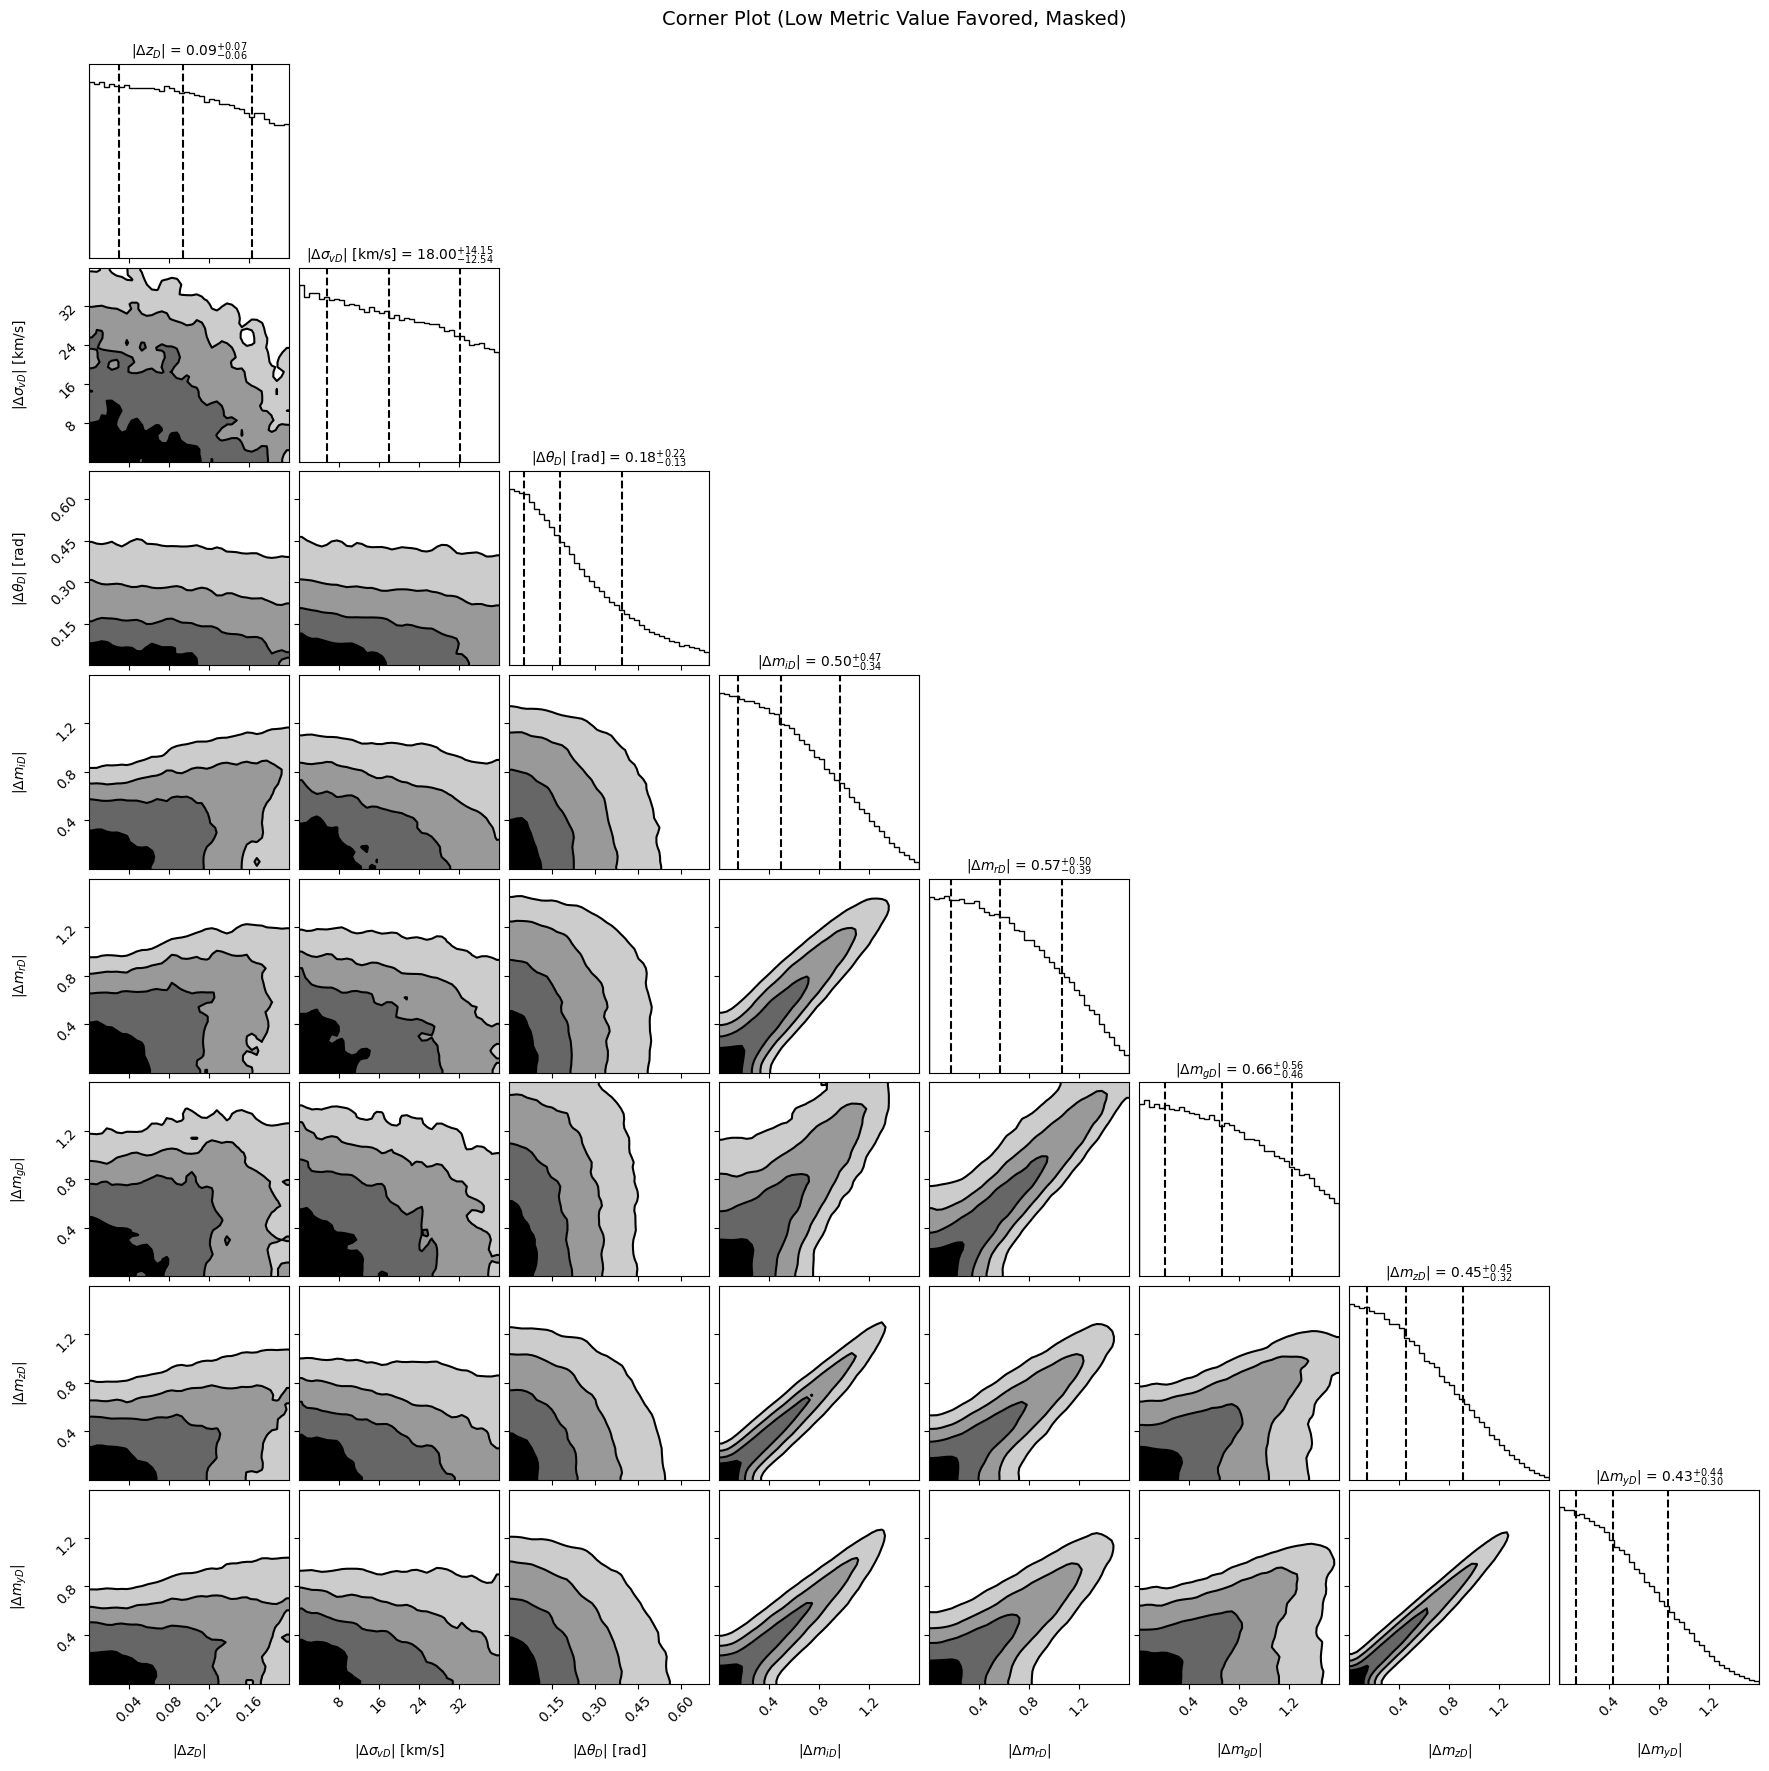

In [6]:
# make a heatmap of abs(theta_E_ratio - theta_E1_by_theta_E2_virtual) and abs(theta_E_ratio - theta_E1_virtual_by_theta_E2) as a function of abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_i_D

# User's parameter keys and labels
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    "abs_delta_mag_i_D",
    "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    "abs_delta_mag_z_D",
    "abs_delta_mag_y_D",
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [rad]",
    "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
}
metric_key = "abs_diff_theta_E_1"

# --- Define the Mask ---
# Make sure the keys used in the mask exist in pairing_parameters!
try:
    mask_condition = ((pairing_parameters["abs_delta_z_D"] < 0.2)
                        & (pairing_parameters["abs_delta_sigma_v_D"] < 40)
                      & (pairing_parameters["abs_delta_size_D"] < 0.7)
                        & (pairing_parameters["abs_delta_mag_i_D"] < 1.6)
                        & (pairing_parameters["abs_delta_mag_r_D"] < 1.6)
                        & (pairing_parameters["abs_delta_mag_g_D"] < 1.6)
                        & (pairing_parameters["abs_delta_mag_z_D"] < 1.6)
                        & (pairing_parameters["abs_delta_mag_y_D"] < 1.6)
                    )
    # mask_condition = None
    print(f"Mask defined. Number of points satisfying mask: {np.sum(mask_condition)}")
except KeyError as e:
    print(f"Error creating mask: Key {e} not found in generated example data. Skipping mask.")
    mask_condition = None # Set mask to None if keys are missing

# Choose the weight conversion method
weight_method = 'chi2'


# --- Call the plotting function ---
print(f"\nPlotting {len(param_keys)} parameters using '{metric_key}' for metric "
        f"(converted via method='{weight_method}').")

figure = plot_low_metric_weighted_corner(
    data_dict=pairing_parameters,
    param_keys=param_keys, # Plot only the generated keys
    metric_key=metric_key,
    labels_dict=latex_labels,
    conversion_method=weight_method,
    mask=mask_condition, # Pass the created mask here
    corner_kwargs={
        # 'truths': true_means,
        'truth_color': 'coral',
        'smooth': 1.0,
        'bins': 40, # Adjust bins based on number of points after masking
    }
)

# --- Show the plot ---
if figure:
    plot_title = "Corner Plot (Low Metric Value Favored"
    if mask_condition is not None:
        plot_title += ", Masked)"
    else:
        plot_title += ")"
    figure.suptitle(plot_title, fontsize=14)
    figure.subplots_adjust(top=0.95)
    plt.show()
else:
    print("Failed to generate corner plot.")

Number of PDSPLs left after the mask: 1020
Fraction of data points left after the mask: 0.019 %
Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual: 0.20623913311574066
Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2: 0.10941418535976064


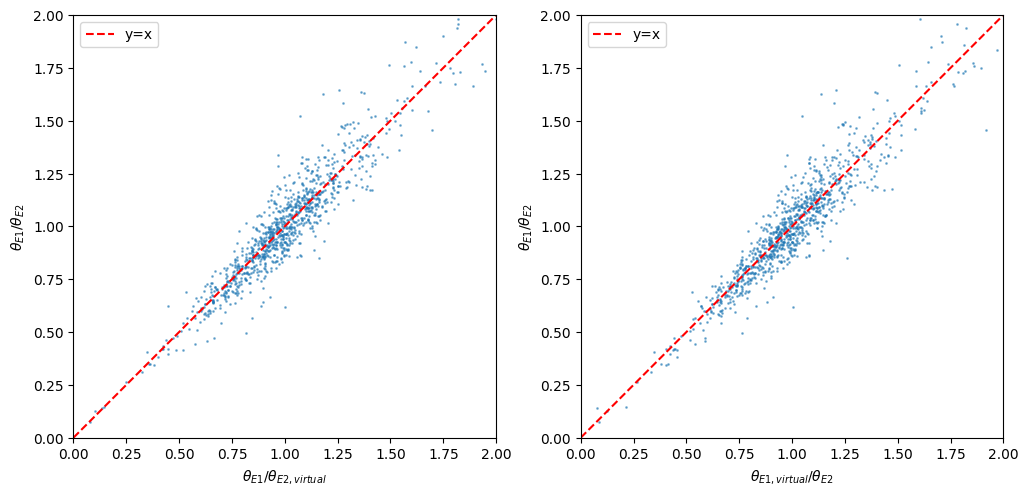

In [7]:
# Therefore the approximate maximum values for the parameters are:
threshold_abs_delta_z_D = 0.06
threshold_abs_delta_sigma_v_D = 8 # km/s
threshold_abs_delta_size_D = 0.07 # rad
threshold_abs_delta_mag_X_D = 0.3 # mag


# plot the theta_E_ratio, theta_E1_by_theta_E2_virtual, theta_E1_virtual_by_theta_E2 after the mask with above values
mask = (
    (pairing_parameters["abs_delta_z_D"] < threshold_abs_delta_z_D)
    & (pairing_parameters["abs_delta_sigma_v_D"] < threshold_abs_delta_sigma_v_D)
    & (pairing_parameters["abs_delta_size_D"] < threshold_abs_delta_size_D)
    & (pairing_parameters["abs_delta_mag_i_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_r_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_g_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_z_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_y_D"] < threshold_abs_delta_mag_X_D)
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot theta_E_ratio vs theta_E1_by_theta_E2_virtual
ax[0].scatter(
    pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
    pairing_parameters["theta_E_ratio"][mask],
    s=1,
    alpha=0.5,
)
ax[0].set_xlabel(r"$\theta_{E1}/\theta_{E2, virtual}$")
ax[0].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")

# Plot theta_E_ratio vs theta_E1_virtual_by_theta_E2
ax[1].scatter(
    pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
    pairing_parameters["theta_E_ratio"][mask],
    s=1,
    alpha=0.5,
)
ax[1].set_xlabel(r"$\theta_{E1, virtual}/\theta_{E2}$")
ax[1].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")

for a in ax:
    a.set_xlim(0, 2)
    a.set_ylim(0, 2)
    a.plot([0, 2], [0, 2], color='red', linestyle='--', label='y=x')
    a.legend()
    a.set_aspect('equal', adjustable='box')

# fig.suptitle(
#     f"Pairing Parameters after Mask",
#     fontsize=16,
#     y=0.95,
# )

# fraction of the data points left after the mask
print(f"Number of PDSPLs left after the mask: {np.sum(mask)}")
print(f"Fraction of data points left after the mask: {round(100*np.sum(mask) / len(mask), 3)} %")


# find the scatter for each plot from the fitted line
print("Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual:", np.std(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_by_theta_E2_virtual"][mask]
))
print("Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2:", np.std(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_virtual_by_theta_E2"][mask]
))

Text(-0.10941418535976064, 15, '')

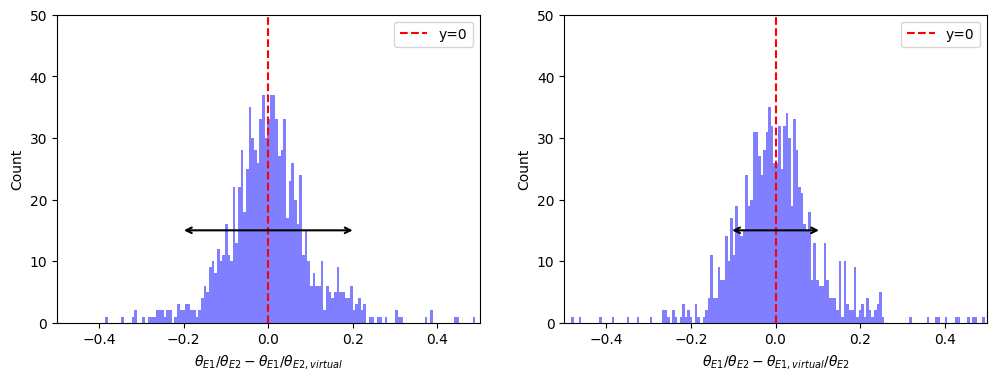

In [20]:
# make histograms of the (theta_E_ratio - theta_E1_by_theta_E2_virtual) and (theta_E_ratio - theta_E1_virtual_by_theta_E2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Plot histogram of theta_E_ratio - theta_E1_by_theta_E2_virtual
ax[0].hist(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
    bins=1000,
    alpha=0.5,
    color='blue',
)
ax[0].set_xlabel(r"$\theta_{E1}/\theta_{E2} - \theta_{E1}/\theta_{E2, virtual}$")
ax[0].set_ylabel("Count")
# Plot histogram of theta_E_ratio - theta_E1_virtual_by_theta_E2
ax[1].hist(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
    bins=200,
    alpha=0.5,
    color='blue',
)
ax[1].set_xlabel(r"$\theta_{E1}/\theta_{E2} - \theta_{E1, virtual}/\theta_{E2}$")
ax[1].set_ylabel("Count")
for a in ax:
    a.set_xlim(-0.5, 0.5)
    a.set_ylim(0, 50)
    a.axvline(0, color='red', linestyle='--', label='y=0')
    a.legend()
    a.set_aspect('auto', adjustable='box')

sigma_first = np.std(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_by_theta_E2_virtual"][mask]
)
sigma_second = np.std(
    pairing_parameters["theta_E_ratio"][mask] - pairing_parameters["theta_E1_virtual_by_theta_E2"][mask]
)

# locate the 1-sigma as double arrow
ax[0].annotate(
    '',
    xy=(sigma_first, 15),
    xytext=(-sigma_first, 15),
    arrowprops=dict(arrowstyle='<->', lw=1.5),
)

ax[1].annotate(
    '',
    xy=(sigma_second, 15),
    xytext=(-sigma_second, 15),
    arrowprops=dict(arrowstyle='<->', lw=1.5),
)

## TEST CODE

Algorithm for finding the best $|Δz_D|$, $|Δσ_{v,D}|$, $|Δm_D|$, $|Δ\theta_D|$ such that the pair can be treated as PDSPL!

1. Make bins of $|Δz_D|$, $|Δσ_{v,D}|$, $|Δm_D|$, $|Δ\theta_D|$.
2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each bin in the grid.
3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$, $|Δσ_{v,D}|_i$, $|Δm_D|_i$, $|Δ\theta_D|_i$.
4. Choose the best bins with the highest correlation.

<Axes: title={'center': 'Heatmap of Abs. Diff. in $\\theta_E$ Ratio (Mean per Bin)'}, xlabel='$|\\Delta z_D|$', ylabel='$|\\Delta m_{iD}|$'>

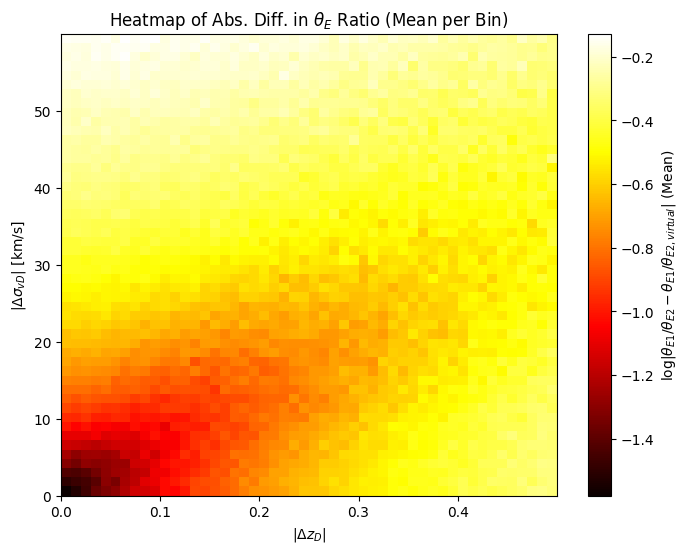

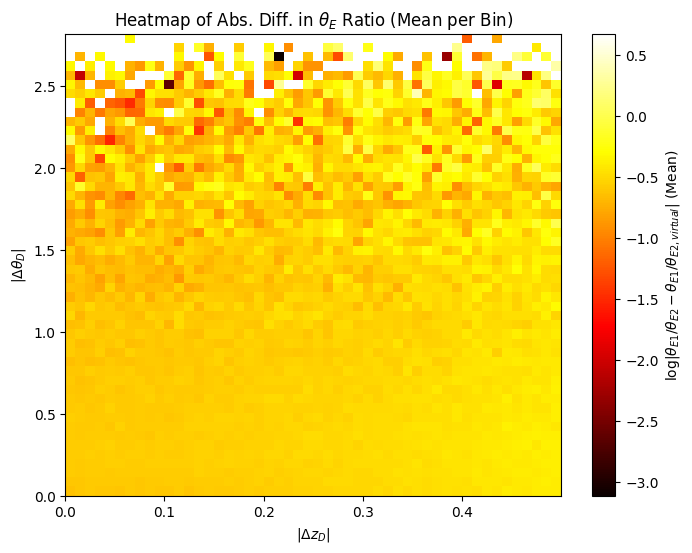

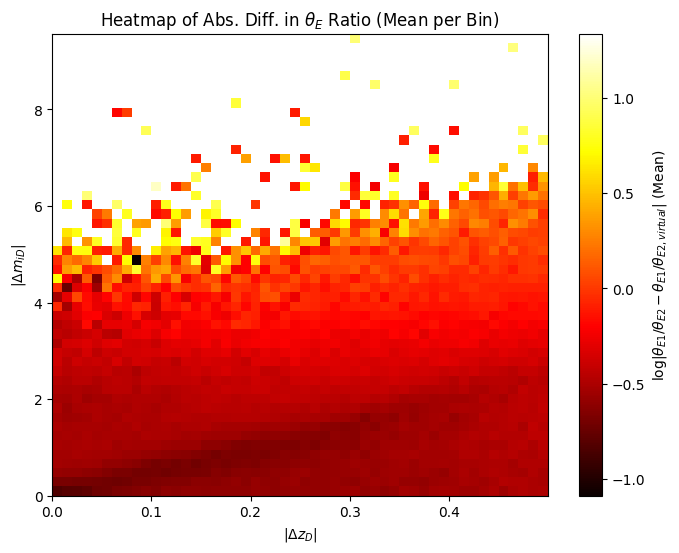

In [36]:
# make a heatmap of abs(theta_E_ratio - theta_E1_by_theta_E2_virtual) and abs(theta_E_ratio - theta_E1_virtual_by_theta_E2) as a function of abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_i_D


mask = (pairing_parameters["abs_delta_z_D"] < 0.5) & (pairing_parameters["abs_delta_sigma_v_D"] < 60)


# define the keys for parameters to plot
keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    "abs_delta_mag_i_D",
    "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    "abs_delta_mag_z_D",
    "abs_delta_mag_y_D",
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
    "abs_delta_size_D": r"$|\Delta \theta_D|$",
    "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
}

## A. delta_z_D vs delta_sigma_v_D

# for the first heatmap
plot_heatmap_fast(
    pairing_parameters["abs_delta_z_D"][mask],
    pairing_parameters["abs_delta_sigma_v_D"][mask],
    np.log10(pairing_parameters["abs_diff_theta_E_1"][mask]),
    x_resolution=50,
    y_resolution=50,
    agg_func='mean',
    xlabel=r"$|\Delta z_D|$",
    ylabel=r"$|\Delta \sigma_{vD}|$ [km/s]",
    zlabel="$\\log|\\theta_{E1}/\\theta_{E2} - \\theta_{E1}/\\theta_{E2, virtual}|$",
    title="Heatmap of Abs. Diff. in $\\theta_E$ Ratio",
    figsize=(8, 6),
    cmap='hot',
)

# # for the second heatmap
# plot_heatmap_fast(
#     pairing_parameters["abs_delta_z_D"][mask],
#     pairing_parameters["abs_delta_sigma_v_D"][mask],
#     np.log10(pairing_parameters["abs_diff_theta_E_2"][mask]),
#     x_resolution=50,
#     y_resolution=50,
#     agg_func='mean',
#     xlabel=r"$|\Delta z_D|$",
#     ylabel=r"$|\Delta \sigma_{vD}|$ [km/s]",
#     zlabel="$\\log|\\theta_{E1}/\\theta_{E2} - \\theta_{E1, virtual}/\\theta_{E2}|$",
#     title="Heatmap of Abs. Diff. in $\\theta_E$ Ratio",
#     figsize=(8, 6),
#     cmap='hot',
# )

## B. delta_z_D vs delta_size_D
# for the first heatmap
plot_heatmap_fast(
    pairing_parameters["abs_delta_z_D"][mask],
    pairing_parameters["abs_delta_size_D"][mask],
    np.log10(pairing_parameters["abs_diff_theta_E_1"][mask]),
    x_resolution=50,
    y_resolution=50,
    agg_func='mean',
    xlabel=r"$|\Delta z_D|$",
    ylabel=r"$|\Delta \theta_D|$",
    zlabel="$\\log|\\theta_{E1}/\\theta_{E2} - \\theta_{E1}/\\theta_{E2, virtual}|$",
    title="Heatmap of Abs. Diff. in $\\theta_E$ Ratio",
    figsize=(8, 6),
    cmap='hot',
)

## C. delta_z_D vs delta_mag_i_D
# for the first heatmap
plot_heatmap_fast(
    pairing_parameters["abs_delta_z_D"][mask],
    pairing_parameters["abs_delta_mag_i_D"][mask],
    np.log10(pairing_parameters["abs_diff_theta_E_1"][mask]),
    x_resolution=50,
    y_resolution=50,
    agg_func='mean',
    xlabel=r"$|\Delta z_D|$",
    ylabel=r"$|\Delta m_{iD}|$",
    zlabel="$\\log|\\theta_{E1}/\\theta_{E2} - \\theta_{E1}/\\theta_{E2, virtual}|$",
    title="Heatmap of Abs. Diff. in $\\theta_E$ Ratio",
    figsize=(8, 6),
    cmap='hot',
)

In [ ]:
## 1. Make bins with abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_X_D 

num_bins = 10

abs_delta_z_D_bins = np.linspace(
    np.min(pairing_parameters["abs_delta_z_D"]),
    np.max(pairing_parameters["abs_delta_z_D"]),
    num_bins,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(pairing_parameters["abs_delta_sigma_v_D"]),
    np.max(pairing_parameters["abs_delta_sigma_v_D"]),
    num_bins,
)
abs_delta_size_D_bins = np.linspace(
    np.min(pairing_parameters["abs_delta_size_D"]),
    np.max(pairing_parameters["abs_delta_size_D"]),
    num_bins,
)
abs_delta_mag_i_D_bins = np.linspace(
    np.min(pairing_parameters["abs_delta_mag_i_D"]),
    np.max(pairing_parameters["abs_delta_mag_i_D"]),
    num_bins,
)
# abs_delta_mag_r_D_bins = np.linspace(
#     np.min(pairing_parameters["abs_delta_mag_r_D"]),
#     np.max(pairing_parameters["abs_delta_mag_r_D"]),
#     num_bins,
# )
# abs_delta_mag_g_D_bins = np.linspace(
#     np.min(pairing_parameters["abs_delta_mag_g_D"]),
#     np.max(pairing_parameters["abs_delta_mag_g_D"]),
#     num_bins,
# )
# abs_delta_mag_z_D_bins = np.linspace(
#     np.min(pairing_parameters["abs_delta_mag_z_D"]),
#     np.max(pairing_parameters["abs_delta_mag_z_D"]),
#     num_bins,
# )
# abs_delta_mag_y_D_bins = np.linspace(
#     np.min(pairing_parameters["abs_delta_mag_y_D"]),
#     np.max(pairing_parameters["abs_delta_mag_y_D"]),
#     num_bins,
# )

# 2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each bin

# rank 4 arrays to store the correlations
correlations_1 = np.zeros(
    (
        len(abs_delta_z_D_bins) - 1,
        len(abs_delta_sigma_v_D_bins) - 1,
        len(abs_delta_size_D_bins) - 1,
        len(abs_delta_mag_i_D_bins) - 1,
    )
)
correlations_2 = np.zeros_like(correlations_1)

# use parallelized functions for calculating the correlations in each bin

def calculate_correlations(i, j, k, l):
    mask = (
        (pairing_parameters["abs_delta_z_D"] > abs_delta_z_D_bins[i])
        & (pairing_parameters["abs_delta_z_D"] < abs_delta_z_D_bins[i+1])
        & (pairing_parameters["abs_delta_sigma_v_D"] > abs_delta_sigma_v_D_bins[j])
        & (pairing_parameters["abs_delta_sigma_v_D"] < abs_delta_sigma_v_D_bins[j+1])
        & (pairing_parameters["abs_delta_size_D"] > abs_delta_size_D_bins[k])
        & (pairing_parameters["abs_delta_size_D"] < abs_delta_size_D_bins[k+1])
        & (pairing_parameters["abs_delta_mag_i_D"] > abs_delta_mag_i_D_bins[l])
        & (pairing_parameters["abs_delta_mag_i_D"] < abs_delta_mag_i_D_bins[l+1])
    )
    if np.sum(mask) > 0:
        corr_1 = np.corrcoef(
            pairing_parameters["theta_E_ratio"][mask],
            pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
        )[0, 1]
        corr_2 = np.corrcoef(
            pairing_parameters["theta_E_ratio"][mask],
            pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
        )[0, 1]
    else:
        corr_1 = np.nan
        corr_2 = np.nan
    return (i, j, k, l, corr_1, corr_2)



# Populate the correlations arrays
for i in range(len(abs_delta_z_D_bins) - 1):
    for j in range(len(abs_delta_sigma_v_D_bins) - 1):
        for k in range(len(abs_delta_size_D_bins) - 1):
            for l in range(len(abs_delta_mag_i_D_bins) - 1):
                i, j, k, l, corr_1, corr_2 = calculate_correlations(i, j, k, l)
                correlations_1[i, j, k, l] = corr_1
                correlations_2[i, j, k, l] = corr_2

/opt/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


TypeError: Invalid shape (9, 9, 9, 9) for image data

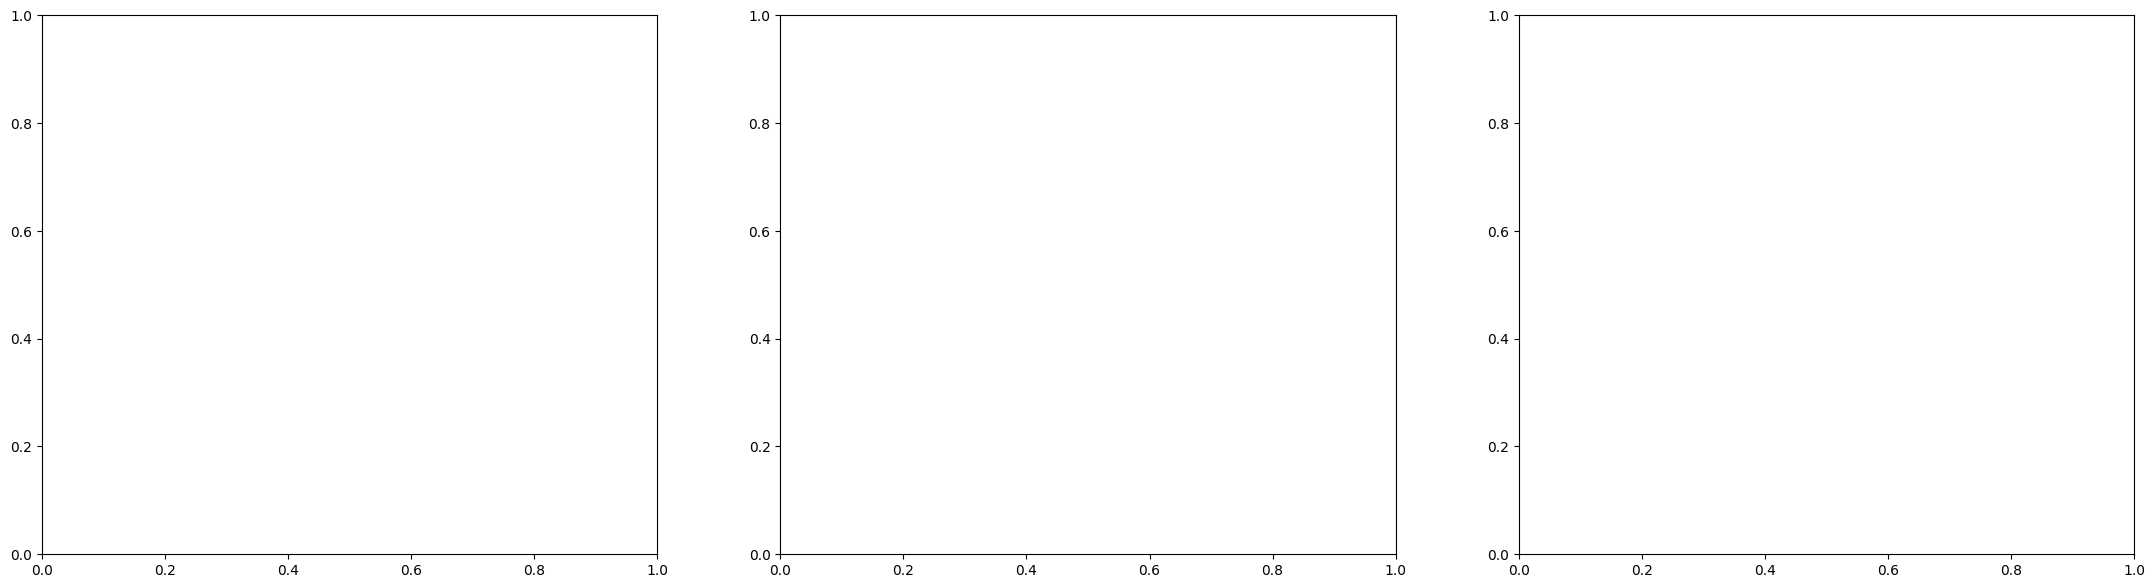

In [13]:
# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

In [144]:
## zoom into the region with |Δz_D| < 0.5 and |Δσ_{vD}| < 60 km/s
## 1. Choose lenses with $|Δz_D| < |Δz_D|_i$ and $|Δσ_D| < |Δσ_D|_j$.
# make bins for $|Δz_D|$ and $|Δσ_D|$.

abs_delta_z_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_z_D"]),
    0.5,
    100,
)
abs_delta_sigma_v_D_bins = np.linspace(
    np.min(filtered_pairing_parameters["abs_delta_sigma_v_D"]),
    60,
    100,
)

# 2. Estimate correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$, or $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$ for each $i, j$.
correlations_1 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
correlations_2 = np.zeros((len(abs_delta_z_D_bins) - 1, len(abs_delta_sigma_v_D_bins) - 1))
for i in range(len(abs_delta_z_D_bins) - 1):
    for j in range(len(abs_delta_sigma_v_D_bins) - 1):
        mask = (
            (filtered_pairing_parameters["abs_delta_z_D"] < abs_delta_z_D_bins[i+1])
            & (filtered_pairing_parameters["abs_delta_sigma_v_D"] < abs_delta_sigma_v_D_bins[j+1])
        )
        if np.sum(mask) > 0:
            correlations_1[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"][mask],
            )[0, 1]
            correlations_2[i, j] = np.corrcoef(
                filtered_pairing_parameters["theta_E_ratio"][mask],
                filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"][mask],
            )[0, 1]
        else:
            correlations_1[i, j] = np.nan
            correlations_2[i, j] = np.nan

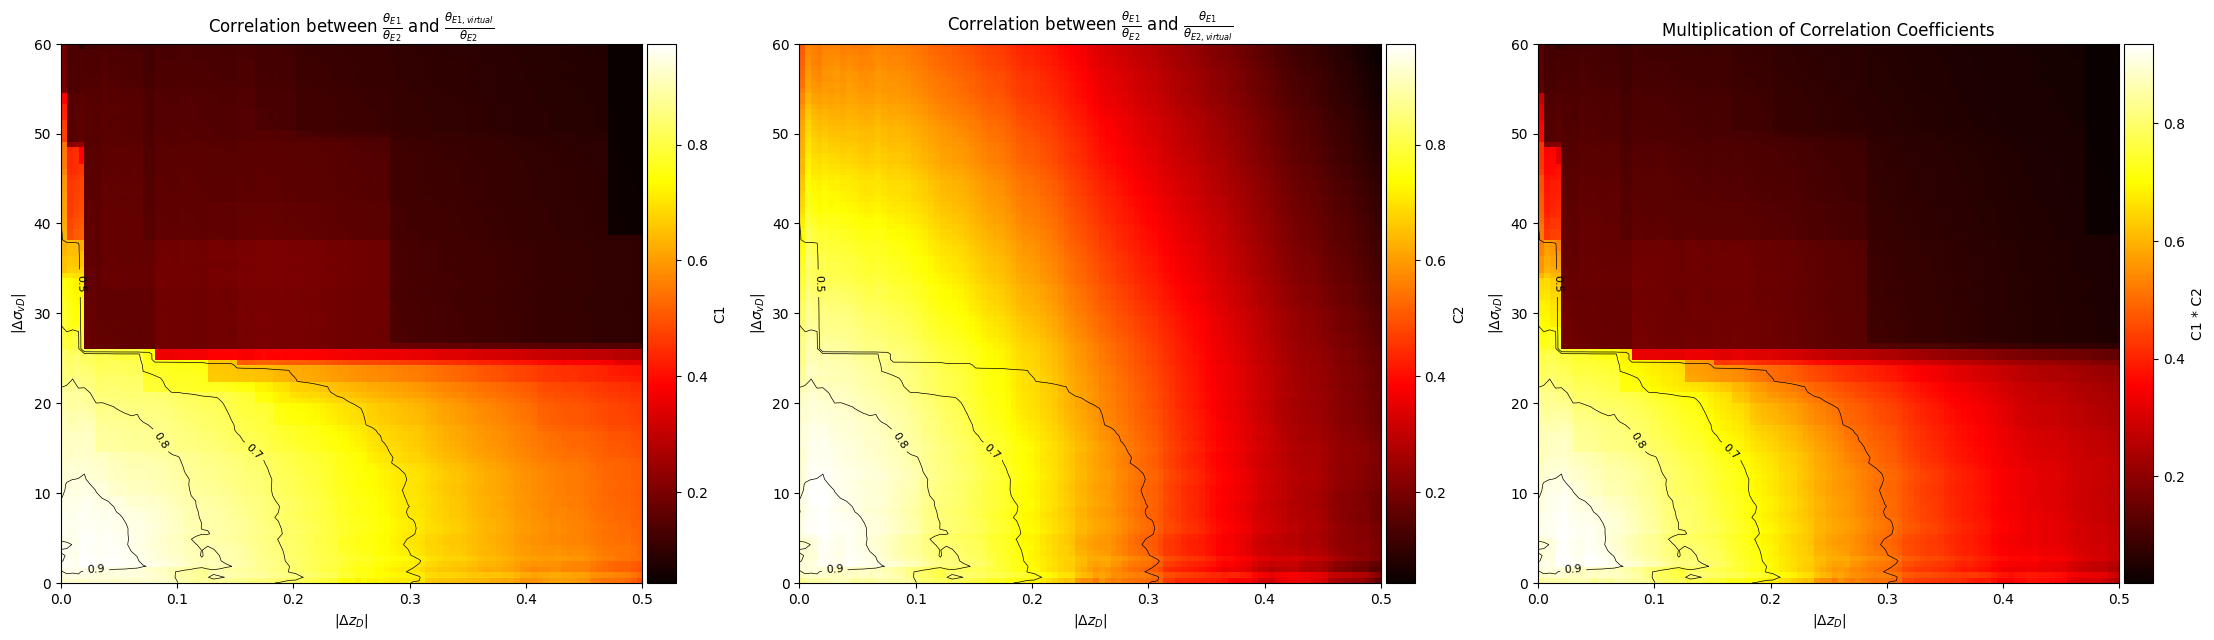

In [147]:
# 3. Then make a heatmap of the correlation and see how it varies with $|Δz_D|_i$ and $|Δσ_D|_j$.
fig, ax = plt.subplots(1, 3, figsize=(27, 7))
im = ax[0].imshow(
    correlations_1,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[0].set_xlabel(r"$|\Delta z_D|$")
ax[0].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[0].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1, virtual}}{\theta_{E2}}$"
)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1")


ax[1].imshow(
    correlations_2,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[1].set_xlabel(r"$|\Delta z_D|$")
ax[1].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[1].set_title(
    r"Correlation between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}}{\theta_{E2, virtual}}$"
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C2")

# multiplication of the two correlation coefficients
correlations = correlations_1 * correlations_2
im = ax[2].imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax[2].set_xlabel(r"$|\Delta z_D|$")
ax[2].set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax[2].set_title(
    r"Multiplication of Correlation Coefficients"
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")


#contours

for ax_ in ax:
    ax_cs = ax_.contour(
        abs_delta_z_D_bins[:-1],
        abs_delta_sigma_v_D_bins[:-1],
        correlations,
        levels=[0.5, 0.7, 0.8, 0.9, 0.95],
        colors="k",
        linewidths=0.5,
    )
    ax_.clabel(
        ax_cs,
        inline=True,
        fontsize=8,
        fmt="%1.1f",
        colors="k",
        use_clabeltext=True,
    )

<a list of 4 text.Text objects>

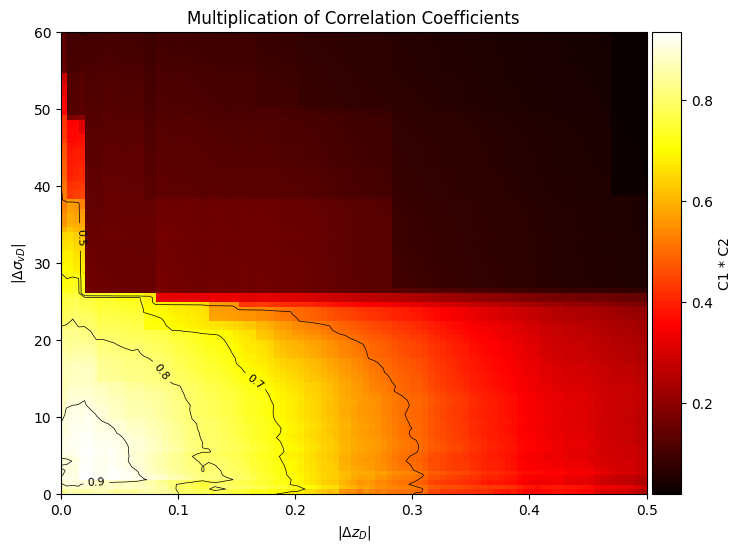

In [ ]:
correlations = correlations_1 * correlations_2

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(
    correlations,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax.set_title(
    r"Multiplication of Correlation Coefficients"
)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 60)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("C1 * C2")

# contours
ax_cs = ax.contour(
    abs_delta_z_D_bins[:-1],
    abs_delta_sigma_v_D_bins[:-1],
    correlations,
    levels=[0.5, 0.7, 0.8, 0.9, 0.95],
    colors="k",
    linewidths=0.5,
)
plt.clabel(
    ax_cs,
    inline=True,
    fontsize=8,
    fmt="%1.1f",
    colors="k",
    use_clabeltext=True,
)

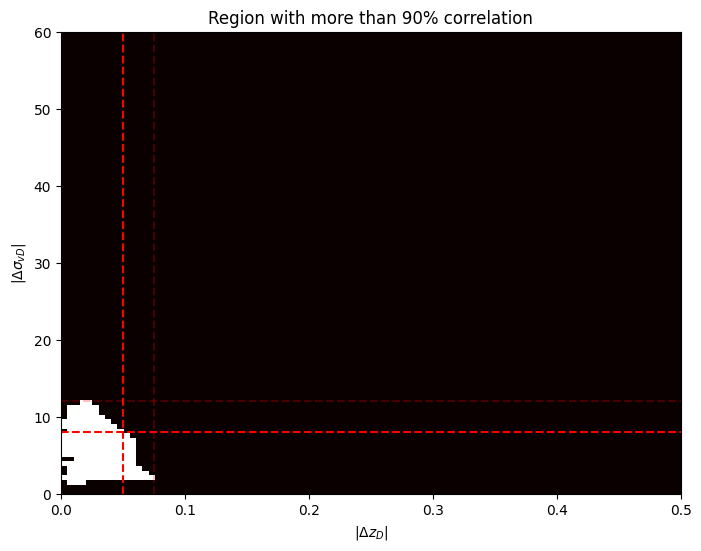

In [160]:
# region with more than 90% correlation
mask = correlations > 0.9
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(
    mask,
    origin="lower",
    aspect="auto",
    extent=[
        abs_delta_z_D_bins[0],
        abs_delta_z_D_bins[-1],
        abs_delta_sigma_v_D_bins[0],
        abs_delta_sigma_v_D_bins[-1],
    ],
    cmap="hot",
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$|\Delta \sigma_{vD}|$")
ax.set_title(
    r"Region with more than 90% correlation"
)

# mark |Δz_D| < 0.05 and |Δσ_{vD}| < 10 km/s

ax.axhline(8, color="r", linestyle="--")
ax.axvline(0.05, color="r", linestyle="--")

ax.axhline(12, color="r", linestyle="--", alpha = 0.25)
ax.axvline(0.075, color="r", linestyle="--", alpha = 0.25)

So the region with more than 90% correlation is the best region to choose $|Δz_D|$ and $|Δσ_D|$. This roughly corresponds to $|Δz_D| < 0.05$ and $|Δσ_D| < 10$ km/s.

<Axes: title={'center': 'Heatmap (Mean per Bin)'}, xlabel='$|\\Delta z_D|$', ylabel='$|\\Delta \\sigma_{vD}|$ [km/s]'>

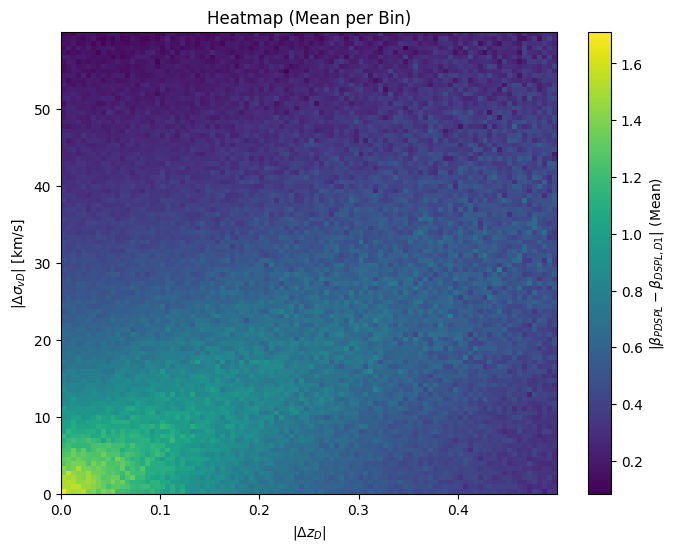

In [63]:
mask = (pairing_parameters['abs_delta_z_D'] < 0.5) & (pairing_parameters['abs_delta_sigma_v_D'] < 60)

plot_heatmap_fast(
    pairing_parameters['abs_delta_z_D'][mask],
    pairing_parameters['abs_delta_sigma_v_D'][mask],
    -np.log10(pairing_parameters['abs_diff_theta_E_1'][mask]),
    x_resolution=100,
    y_resolution=100,
    xlabel=r"$|\Delta z_D|$",
    ylabel=r"$|\Delta \sigma_{vD}|$ [km/s]",
    zlabel=r"$|\beta_{PDSPL} - \beta_{DSPL,D1}|$",
)